# Задание 2 - колокация/pmi

In [1]:
import itertools
import re

from string import punctuation

import gensim
import numpy as np
import nltk
nltk.download('stopwords')

from razdel import sentenize
from razdel import tokenize as razdel_tokenize
from pymorphy2 import MorphAnalyzer
from collections import Counter, defaultdict
from tqdm.auto import tqdm
from nltk.corpus import stopwords

stops = set(stopwords.words('russian') + ["это", "весь"])
morph = MorphAnalyzer()

def normalize(text):
    tokens = re.findall('[а-яёa-z0-9]+', text.lower())
    normalized_text = [morph.parse(word)[0].normal_form for word \
                                                            in tokens]
    normalized_text = [word for word in normalized_text if len(word) > 2 and word not in stops]
    
    return normalized_text

def preprocess(text):
    sents = list(sentenize(text))
    return [normalize(sent.text) for sent in tqdm(sents)]

def ngrammer(tokens, stops, n=2):
    ngrams = []
    tokens = [token for token in tokens if token not in stops]
    for i in range(0,len(tokens)-n+1):
        ngrams.append(tuple(tokens[i:i+n]))
    return ngrams

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [2]:
corpus = open('data/lenta.txt').read()

In [3]:
corpus = preprocess(corpus)

### PMI
Из вики можно высмотреть следующую формулу для Point-wise Mutual information:
$$\operatorname {pmi} (x;y)\equiv \log {\frac {p(x,y)}{p(x)p(y)}}=\log {\frac {p(x|y)}{p(x)}}=\log {\frac {p(y|x)}{p(y)}}$$
Где p(x, y) - вероятность биграммы "x y":
$$p(x,y) = \frac{Count(x,y)}{CorpusWordCount}$$
И p(x), p(y) -  вероятности униграмм "x" и "y":
$$p(x) = \frac{Count(x)}{CorpusWordCount}$$
$$p(y) = \frac{Count(y)}{CorpusWordCount}$$
Реализуем эту функцию:

In [4]:
def pmi(worda_count, wordb_count, bigram_count, len_vocab, min_count, corpus_word_count):
    if bigram_count < min_count:
        return -np.inf # слишком низкочастотное
    
    p_a = np.divide(worda_count, corpus_word_count)
    p_b = np.divide(wordb_count, corpus_word_count)
    p_ab = np.divide(bigram_count, corpus_word_count)
    score = np.log(p_ab / (p_a * p_b))
    return score

In [5]:
def visualize(p):
    list_of_tokens = []
    for i in tqdm(range(len(corpus))):
        list_of_tokens += p[corpus[i]]
        
    list_of_tokens = list(filter(lambda x: "_" in x, list_of_tokens))
    return Counter(list_of_tokens)

### Пробуем с минимальным threshold

In [6]:
ph = gensim.models.Phrases(tqdm(corpus), scoring=pmi, threshold=-1.0)
p = gensim.models.phrases.Phraser(ph)
visualize(p).most_common(20)

[('сообщать_риа', 1158),
 ('риа_новость', 916),
 ('настоящий_время', 787),
 ('владимир_путин', 731),
 ('миллион_доллар', 496),
 ('передавать_риа', 491),
 ('сообщить_риа', 481),
 ('премьер_министр', 439),
 ('президент_россия', 416),
 ('2000_год', 403),
 ('правоохранительный_орган', 400),
 ('пресс_служба', 391),
 ('сообщать_интерфакс', 384),
 ('новость_ссылка', 361),
 ('федеральный_сила', 360),
 ('северный_кавказ', 343),
 ('санкт_петербург', 326),
 ('1999_год', 317),
 ('сообщать_агентство', 315),
 ('принять_решение', 310)]

### Попробуем посмотреть на распределение скора

In [7]:
import matplotlib.pylab as plt
%matplotlib inline
import seaborn as sns

In [8]:
phrasegrams = list(p.phrasegrams.items())

In [9]:
phrasegrams = list(map(lambda t: (list(map(lambda x: x.decode(), t[0])), t[1]), phrasegrams))

In [10]:
scores = list(map(lambda x: x[1], phrasegrams))

/usr/local/lib/python3.8/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:ylabel='Density'>

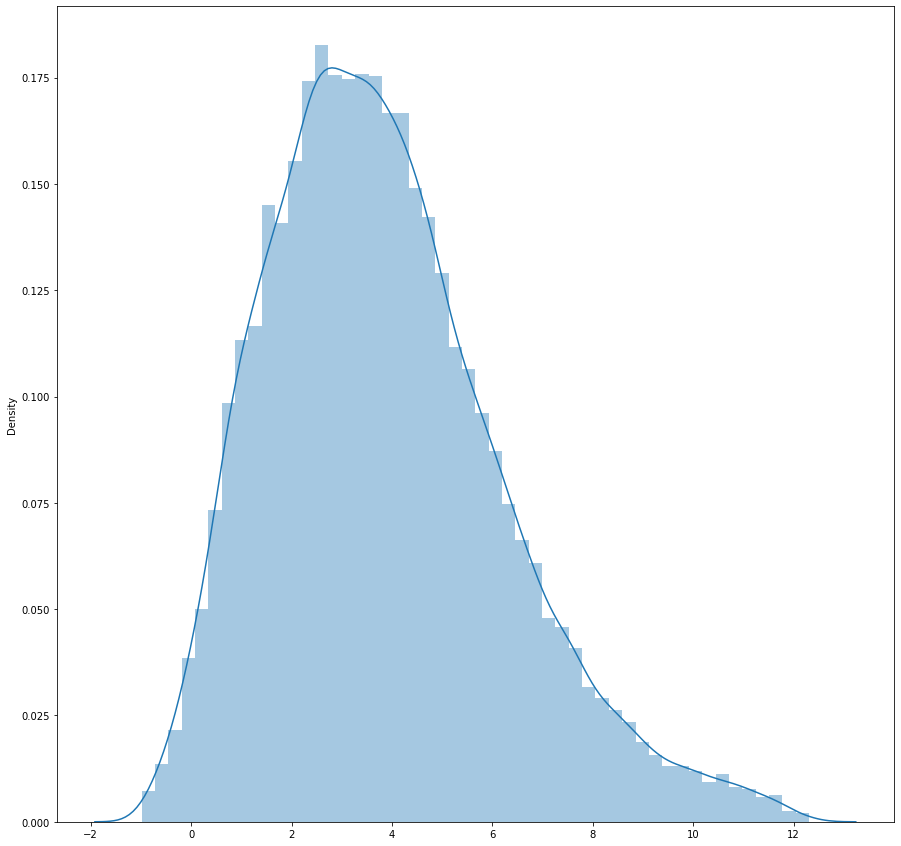

In [11]:
ig, ax = plt.subplots(figsize=(15.0, 15.0))
sns.distplot(scores, ax=ax)

### Так-как биграмм в принципе больше чем коллокаций - нас скорее всего интересует крайний правый кусочек этого распределения

In [12]:
ph = gensim.models.Phrases(tqdm(corpus), scoring=pmi, threshold=9.8)
p = gensim.models.phrases.Phraser(ph)
visualize(p).most_common(40)

[('wall_street', 53),
 ('подписка_невыезд', 44),
 ('сьерра_леон', 40),
 ('эхуд_барак', 35),
 ('рассесть_джонстон', 33),
 ('брюшной_тиф', 32),
 ('норильский_никель', 30),
 ('итум_калинский', 30),
 ('шкала_рихтер', 29),
 ('dow_jones', 28),
 ('кофи_аннана', 27),
 ('exit_polls', 26),
 ('сбс_агро', 25),
 ('русь_алексий', 25),
 ('волгонефть_147', 25),
 ('арби_бараев', 24),
 ('воздушно_десантный', 24),
 ('ясир_арафат', 23),
 ('general_motors', 23),
 ('манчестер_юнайтед', 23),
 ('кабардино_балкария', 22),
 ('джек_стро', 22),
 ('мишель_камдесся', 22),
 ('йорг_хайдер', 22),
 ('элла_памфилов', 22),
 ('турнирный_таблица', 22),
 ('взлётный_посадочный', 21),
 ('шри_ланка', 21),
 ('слободан_милошевич', 21),
 ('петропавловск_камчатский', 21),
 ('вихрь_антитеррор', 19),
 ('охотничий_ружьё', 19),
 ('черепный_мозговой', 19),
 ('иосиро_морить', 19),
 ('сердечный_приступ', 18),
 ('philip_morris', 18),
 ('аум_синрик', 18),
 ('саддам_хусейн', 18),
 ('генри_резник', 18),
 ('pentium_iii', 17)]

## Выглядит неплохо
В основном колокации выделены среди персоналий/имен компаний/географических обозначений + есть несколько общепринятых устойчивых выражений

Можно пробовать уменьшать threshold, но тогда появляются обороты, специфичные для новостных текстов, вряд-ли они будут коллокациями вне новостного домена